# Bottom DO

A simple notebook to generate dissolved oxygen plots for the bottom layer, either for a single run or to compare multiple runs side-by-side.

## Parameters

* `do_data_cdf`: The NetCDF file containing DO results. This is generated using one of the extraction notebooks or [rawcdf_extract.py](rawcdf_extract.py).
* `do_variables`: The NetCDF variable names to output. The first variable will be treated as a control which other runs are compared against on the comparison plots.
* `start_date`: A date string to use as day 0 when formatting plot time axes.
* `domain_out_shp`: The shapefile that defines the node areas in the analysis domain. This is generated with [ProcessGrid.ipynb](ProcessGrid).
* `ssm_full_union_shp`: The shapefile that defines the complete SSM model grid as a single polygon. This is generated with [ProcessGrid.ipynb](ProcessGrid) and is only used to depict the water boundary/geography.
* `masked_nodes_txt`: The text file containing a list of node IDs that must be masked from the domain. This is generated with [ProcessGrid.ipynb](ProcessGrid) based on an Ecology-provided geodatabase [here](https://fortress.wa.gov/ecy/ezshare/EAP/SalishSea/SalishSeaModelBoundingScenarios.html), but it can be easily modified to add new cell masks for any additional discharge locations. For details on model output masking, see [Ecology's 2021 Technical Memorandum](https://www.ezview.wa.gov/Portals/_1962/Documents/PSNSRP/OptimizationScenarioTechMemo_9_13_2021.pdf). *Masking nodes in this notebook is extremely slow!* It is much more efficient to perform this masking as part of the raw NetCDF extraction step.
* `sites`: A dict of node numbers and corresponding labels for locations that get dedicated timeseries plots of bottom DO.

In [1]:
do_data_cdf = "model_results/bottom do 2008.nc"
do_variables = ('reference', 'existing')
start_date = "2008-01-01"
domain_out_shp = "gis/ssm filled domain nodes.shp"
ssm_full_union_shp = "gis/ssm full union.shp"
masked_nodes_txt = "gis/masked nodes.txt"

sites = {
    7786: "Admiralty Inlet South",
    12166: "East Passage",
    15490: "Budd Inlet",
    13789: "Lynch Cove"
}

from pathlib import Path
import os.path as path
from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean
import matplotlib.colors as colors
import analysis_util as au
#%matplotlib widget
%matplotlib inline

In [2]:
do_data = Dataset(do_data_cdf)
do_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(8760), node(6120)
    variables(dimensions): int32 node(node), float32 time(time), float32 existing(time, node), float32 reference(time, node)
    groups: 

Determine the timestep of the output (needed for hypoxic duration calculations later)

In [3]:
timestep = do_data['time'][2] - do_data['time'][1]
timestep

0.041666668

Determine the name to use for output files.

All outputs will be in the `notebook_outs` directory. They will start with the base name (without extension) of the given NetCDF file, followed by `_botdo_`, then a descriptive name of the output.

In [4]:
out_base = Path(do_data_cdf).stem
out_file = lambda name: path.join("notebook_outs", out_base + "_botdo_" + name)

Remove any 'DOXG_bottom" suffixes for friendlier plot titles

In [5]:
# I would use str.removesuffix here but that's not available until Python 3.9
def removesuffix(string, suffix):
    if len(string) < len(suffix):
        # That suffix must not be present
        return string
    elif string[-len(suffix):] == suffix:
        return string[:-len(suffix)]
    else:
        return string
do_variable_titles = [removesuffix(s, 'DOXG_bottom') for s in do_variables]
do_variable_titles

['reference', 'existing']

In [6]:
domain = gpd.read_file(domain_out_shp)
domain.set_index('node_id', inplace=True)
domain.head()

,depth,geometry
node_id,,
4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5..."
4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5..."
4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5..."
4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5..."
4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5..."


Remove masked nodes from the domain. This must be done regardless of whether or not they need to be masked in the NetCDF output given. Use the node counts before and after to determine if masking of the NetCDF output is necessary.

In [7]:
nodes_unmasked = len(domain)
print("Total nodes before masking: ", nodes_unmasked)

need_to_mask = (nodes_unmasked == do_data.dimensions['node'].size)
if need_to_mask:
    print("** We will need to do masking inline, things are about to slow down!")

masked_nodes = np.loadtxt(masked_nodes_txt)
domain = domain.loc[~domain.index.isin(masked_nodes)]

print("Total nodes after masking: ", len(domain))

assert need_to_mask or (len(domain) == do_data.dimensions['node'].size), "Number of nodes in data file do not match the domain shapefile!"

domain.head()

Total nodes before masking:  6120
** We will need to do masking inline, things are about to slow down!
Total nodes after masking:  4446


,depth,geometry
node_id,,
4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5..."
4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5..."
4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5..."
4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5..."
4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5..."


Build an array of all node dimension indices in the output that correspond to unmasked areas

In [8]:
if need_to_mask:
    unmasked_indexer = np.isin(do_data['node'][:], domain.index.to_numpy()).nonzero()[0]
    print(unmasked_indexer.shape)
else:
    unmasked_indexer = slice(None)
unmasked_indexer

(4446,)


array([   0,    1,    2, ..., 6114, 6117, 6119])

In [9]:
au.read_base_map(ssm_full_union_shp).head()

,FID,geometry
0,0,"POLYGON ((146157.500 5556772.500, 144805.000 5..."


# Bottom DO for Selected Sites

Produce a timeseries of bottom DO at each of the sites defined in the `sites` variable, along with a corresponding Excel workbook that contains one sheet per site.

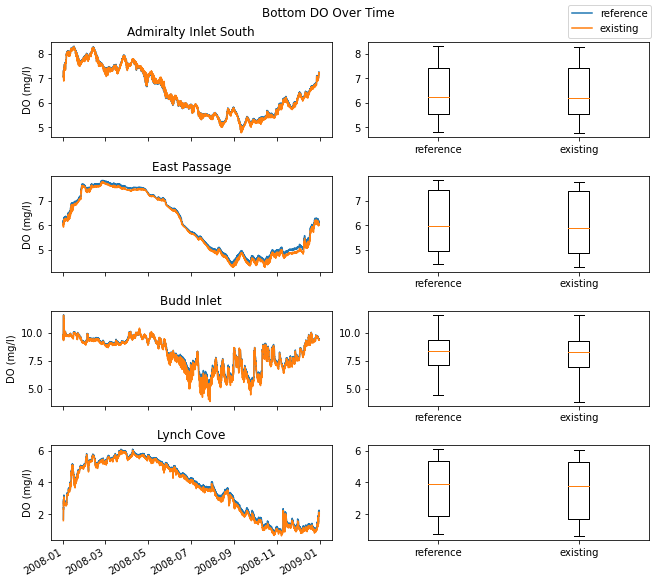

In [10]:
fig, axs = plt.subplots(len(sites), 2, constrained_layout=True, figsize=(9, len(sites)*2))
times = do_data['time'][:]
dates = pd.Timestamp(start_date) + pd.to_timedelta(times, 'd')
with pd.ExcelWriter(out_file("sites.xlsx")) as writer:
    # Iterate over all the specified sites, along with a dedicated plot Axes per site
    for ax,(n,s) in zip(axs, sites.items()):
        tsax, boxax = ax
        idx = np.nonzero(do_data['node'][:] == n)[0][0]
        data = {}
        lbl = "{0} ({1})".format(s, n)
        # Plot all the required variables on this Axes
        for v, t in zip(do_variables, do_variable_titles):
            data[t] = do_data[v][:,idx]
            tsax.plot(dates, data[t], label=t)
        tsax.set(title=s, ylabel="DO (mg/l)")

        boxax.boxplot(data.values(), labels=data.keys())

        df = pd.DataFrame(data, index=dates)
        df.to_excel(writer, sheet_name=lbl)

# Implement autofmt_xdate() by hand because it breaks subplot title placement
# Turn off xaxis labels on all but the last Axes
for ax in axs[:-1]:
    ax[0].set_xticklabels(())
# Orient the date labels properly on the lowest Axes
for l in axs[-1,0].get_xticklabels():
    l.set_ha('right')
    l.set_rotation(30)

fig.suptitle("Bottom DO Over Time")
# One common legend. https://stackoverflow.com/a/46921590/413862
handles, labels = axs[-1,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

fig.savefig(out_file("sites.png"))

## Hypoxia

Pre-calculate the hypoxic durations and areas for each variable. If masking is enabled, this takes a while because of the indexer on the NetCDF dataset.

In [11]:
# Representative areas of each node in km2
areas = domain.loc[do_data['node'][unmasked_indexer].data].area / 1e6
# Total area in km2
total_area = areas.sum()

def extract_data(var):
    return do_data[var][:,unmasked_indexer].data

# Calculate the total time that this retrieved node index spent with a hypoxic DO
def calc_duration(data, i):
    return np.count_nonzero(data[:,i] < 2) * timestep

def calc_area(data, t):
    return areas.loc[data[t,:] < 2].sum()

extracted_data = {}
hypoxic_durations = {}
hypoxic_areas = {}
max_duration = 0

for v in do_variables:
    extracted_data[v] = extract_data(v)
    hypoxic_durations[v] = np.zeros(extracted_data[v].shape[1])
    for n in range(len(hypoxic_durations[v])):
        hypoxic_durations[v][n] = calc_duration(extracted_data[v], n)
    max_duration = max(max_duration, hypoxic_durations[v].max())
    hypoxic_areas[v] = np.zeros(extracted_data[v].shape[0])
    for t in range(len(hypoxic_areas[v])):
        hypoxic_areas[v][t] = calc_area(extracted_data[v], t)

# Assemble a DataFrame of all the hypoxic area timeseries for each variable
hypoxic_areas_df = pd.DataFrame(hypoxic_areas, index=dates)

print("Max hypoxic duration: {:.2f} days".format(max_duration))
hypoxic_areas_df.head()

Max hypoxic duration: 149.67 days


,reference,existing
2008-01-01 00:00:00.000000000,14.280415,14.754621
2008-01-01 01:00:00.000115199,14.172613,14.387492
2008-01-01 02:00:00.000230399,14.172613,14.866838
2008-01-01 03:00:00.000000000,13.140456,14.439836
2008-01-01 04:00:00.000460799,8.396650,9.463029


## Hypoxic Duration

Create one plot per DO variable showing the hypoxic duration in days for each node. Also generates an ESRI shapefile that can be loaded into GIS software with the same information, and an Excel spreadsheet.

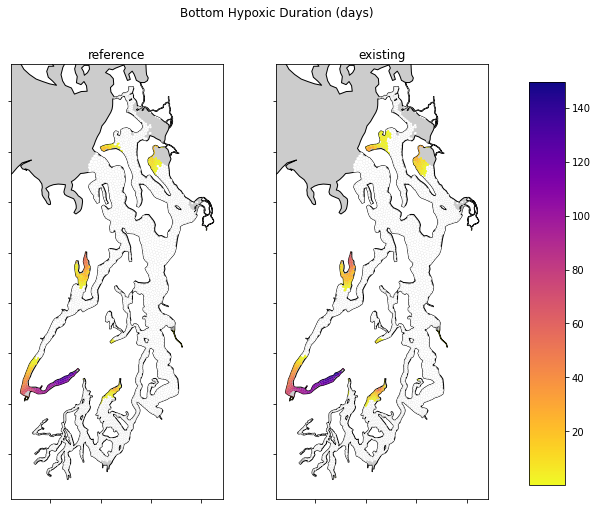

In [12]:
mycmap = cm.get_cmap("plasma_r").copy()
mycmap.set_under('white', 1)

fig, axs = plt.subplots(1, len(do_variables), figsize=(5*len(do_variables), 8))

# Normalize all the durations so the colors match between the plots
norm_duration = colors.Normalize(vmin=0.1, vmax=max_duration)

# Make a map of the durations for each variable, assembling them into one single
# GeoDataFrame for output
for ax, v, t in zip(axs, do_variables, do_variable_titles):
    if ax == axs[-1]:
        # See https://stackoverflow.com/a/13784887/413862 and
        # https://geopandas.org/en/latest/docs/user_guide/mapping.html#creating-a-legend
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        legend_args = { "legend": True, "cax": cbar_ax }
    else:
        legend_args = { "legend": False }
    d, drop = au.map_plot(domain, hypoxic_durations[v], t, ax=ax, cmap=mycmap, norm=norm_duration,
                          **legend_args)
    # A bit of a hack to combine all the durations into a single GeoDataFrame
    if ax == axs[0]:
        data = d
        data.rename(columns={"values": t}, inplace=True)
    else:
        data[t] = d['values']
        
fig.suptitle("Bottom Hypoxic Duration (days)")

fig.savefig(out_file("hypox_duration.png"))
data.to_file(out_file("hypox_duration.shp"))
data['node_area_km2'] = data['geometry'].area / 1e6
data.to_excel(out_file("hypox_duration.xlsx"))

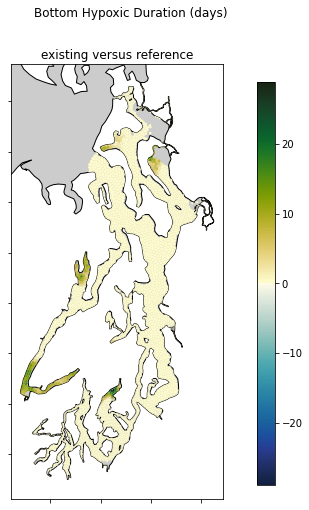

In [13]:
if len(do_variables) > 1:

    duration_diffs = [hypoxic_durations[v] - hypoxic_durations[do_variables[0]] for v in do_variables[1:]]

    fig, axs = plt.subplots(1, len(do_variables) - 1, figsize=(5*(len(do_variables) - 1), 8))

    # For compatibility in the case that there's only a single plot to make
    if len(do_variables) == 2:
        axs = np.array([axs])
    
    divnorm = colors.CenteredNorm(halfrange=np.max(np.abs(duration_diffs)))

    # Make a map of the duration difference between each variable and the control
    for ax, v, t in zip(axs, duration_diffs, do_variable_titles[1:]):
        if ax == axs[-1]:
            # See https://stackoverflow.com/a/13784887/413862 and
            # https://geopandas.org/en/latest/docs/user_guide/mapping.html#creating-a-legend
            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            legend_args = { "legend": True, "cax": cbar_ax }
        else:
            legend_args = { "legend": False }
        d, drop = au.map_plot(domain, v, f'{t} versus {do_variable_titles[0]}', ax=ax,
                              cmap=cmocean.cm.delta, norm=divnorm, **legend_args)
            
fig.suptitle("Bottom Hypoxic Duration (days)")
fig.savefig(out_file("hypox_duration_compare.png"))

## Hypoxic Area

Generate a timeseries plot of each DO variable's total hypoxic area over the runtime of the model, plus an Excel spreadsheet containing the timeseries data.

reference: Max hypoxic area 74.89 km2 on 2008-12-23
existing: Max hypoxic area 86.42 km2 on 2008-09-24


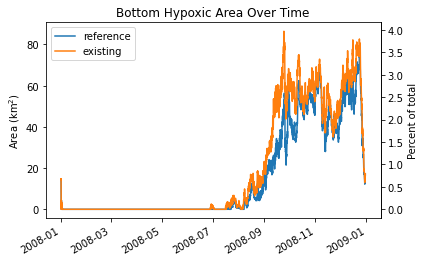

In [14]:
# Plot each DF column and print the maximum value
fig, ax = plt.subplots()
for v, t in zip(do_variables, do_variable_titles):
    ax.plot(hypoxic_areas_df[v], label=t)
    print("{0}: Max hypoxic area {1:.2f} km2 on {2}".format(t, hypoxic_areas_df[v].max(),
                                                            hypoxic_areas_df[v].idxmax().date()))
ax.set(title="Bottom Hypoxic Area Over Time", ylabel="Area (km$^2$)")
fig.autofmt_xdate()
ax.legend()

# Build a secondary y-axis with the total area percentage
def area_to_pct(a):
    return a * 100 / total_area
def pct_to_area(p):
    return p / 100 * total_area

secax = ax.secondary_yaxis('right', functions=(area_to_pct, pct_to_area))
secax.set_ylabel("Percent of total")

fig.savefig(out_file("hypoxic_area.png"))
hypoxic_areas_df.to_excel(out_file("hypoxic_area.xlsx"))

## Low DO Comparison

Compare DOmin and DO at the 0.1 quantile

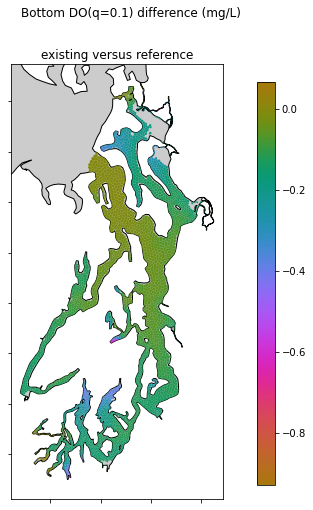

In [15]:
def plot_quantile(q):
    qdesc = f'q={q}' if q > 0 else 'min'

    vals = [np.quantile(extracted_data[v], q, axis=0) for v in do_variables]

    fig, axs = plt.subplots(1, len(do_variables) - 1, figsize=(5*(len(do_variables) - 1), 8))

    norm_do = colors.Normalize(vmin=np.min(vals[1:] - vals[0]), vmax=np.max(vals[1:] - vals[0]))
    
    # For compatibility in the case that there's only a single plot to make
    if len(do_variables) == 2:
        axs = np.array([axs])

    # Make a map of this quantile for each variable compared to the control, assembling
    # them into one single GeoDataFrame for output
    for ax, v, t in zip(axs, vals[1:], do_variable_titles[1:]):
        if ax == axs[-1]:
            # See https://stackoverflow.com/a/13784887/413862 and
            # https://geopandas.org/en/latest/docs/user_guide/mapping.html#creating-a-legend
            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            legend_args = { "legend": True, "cax": cbar_ax }
        else:
            legend_args = { "legend": False }
        d, drop = au.map_plot(domain, v - vals[0], f'{t} versus {do_variable_titles[0]}', ax=ax,
                              cmap=cmocean.cm.phase, norm=norm_do, **legend_args)
    data = domain.copy()
    for v, t in zip(vals, do_variable_titles):
        data[t] = v
    
    fig.suptitle(f'Bottom DO({qdesc}) difference (mg/L)')

    fig.savefig(out_file(f'do_{qdesc}.png'))
    data.to_file(out_file(f'do_{qdesc}.shp'))
    data['node_area_km2'] = data['geometry'].area / 1e6
    data.to_excel(out_file(f'do_{qdesc}.xlsx'))

if len(do_variables) > 1:
    plot_quantile(0.1)